# NLP with Disaster Tweets Kaggle Mini-Project

## 1. Problem and Data Overview

This project tackles the Kaggle competition "Natural Language Processing with Disaster Tweets".
The objective is to build a machine learning model that classifies whether a given tweet is about a real disaster (target=1) or not (target=0).

The data includes the tweet text (`text`), a keyword from the tweet (`keyword`), and the location from which the tweet was sent (`location`). Both `keyword` and `location` may be blank.
The evaluation metric is the F1 score.

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# NLTK for stopwords (if needed)
import nltk
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
from nltk.corpus import stopwords

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

print("Required libraries imported.")

Required libraries imported.


### Loading the Data

Load the training data (`train.csv`) and test data (`test.csv`).

In [186]:
# Specify the directory where the data is downloaded
data_dir = './nlp-getting-started/'

try:
    train_df = pd.read_csv(data_dir + 'train.csv')
    test_df = pd.read_csv(data_dir + 'test.csv')
    sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

    print("Data loading complete.")
    print(f"Training data size: {train_df.shape}")
    print(f"Test data size: {test_df.shape}")
except FileNotFoundError:
    print(f"Error: Files not found in {data_dir}. Please check the path.")

Data loading complete.
Training data size: (7613, 5)
Test data size: (3263, 4)


### Inspecting the Data

In [187]:
print("--- Training Data (First 5 rows) ---")
display(train_df.head())

print("\n--- Test Data (First 5 rows) ---")
display(test_df.head())

print("\n--- Training Data Info ---")
train_df.info()

--- Training Data (First 5 rows) ---


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



--- Test Data (First 5 rows) ---


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan



--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## 2. Exploratory Data Analysis (EDA)

Perform EDA to understand the data characteristics and plan the analysis approach.

### 2.1 Checking for Missing Values

In [188]:
print("--- Missing Values in Training Data ---")
print(train_df.isnull().sum())

print("\n--- Missing Values in Test Data ---")
print(test_df.isnull().sum())

--- Missing Values in Training Data ---
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

--- Missing Values in Test Data ---
id             0
keyword       26
location    1105
text           0
dtype: int64


Both `keyword` and `location` contain a significant number of missing values.
`keyword` has 61 missing values in the training data and 26 in the test data.
`location` has even more missing values: 2533 in the training data and 1105 in the test data.

How to handle these missing values (e.g., deletion, imputation, using them as a feature) will be considered later.

### 2.2 Target Variable Distribution

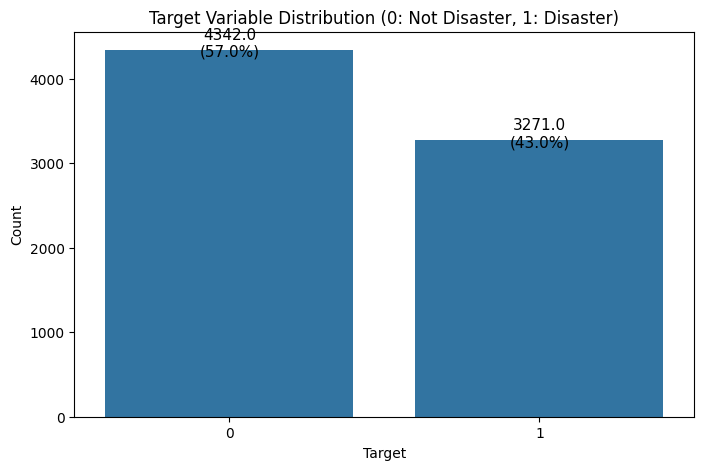

In [189]:
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=train_df)
plt.title('Target Variable Distribution (0: Not Disaster, 1: Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
# Add counts on top of bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(train_df)*100:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

Checked the distribution of the target variable.
- 0 (Not Disaster): Approx. 57%
- 1 (Disaster): Approx. 43%
The class imbalance is not severe, but this might be one reason why the F1 score is specified as the evaluation metric.

### 2.3 Text Length Analysis

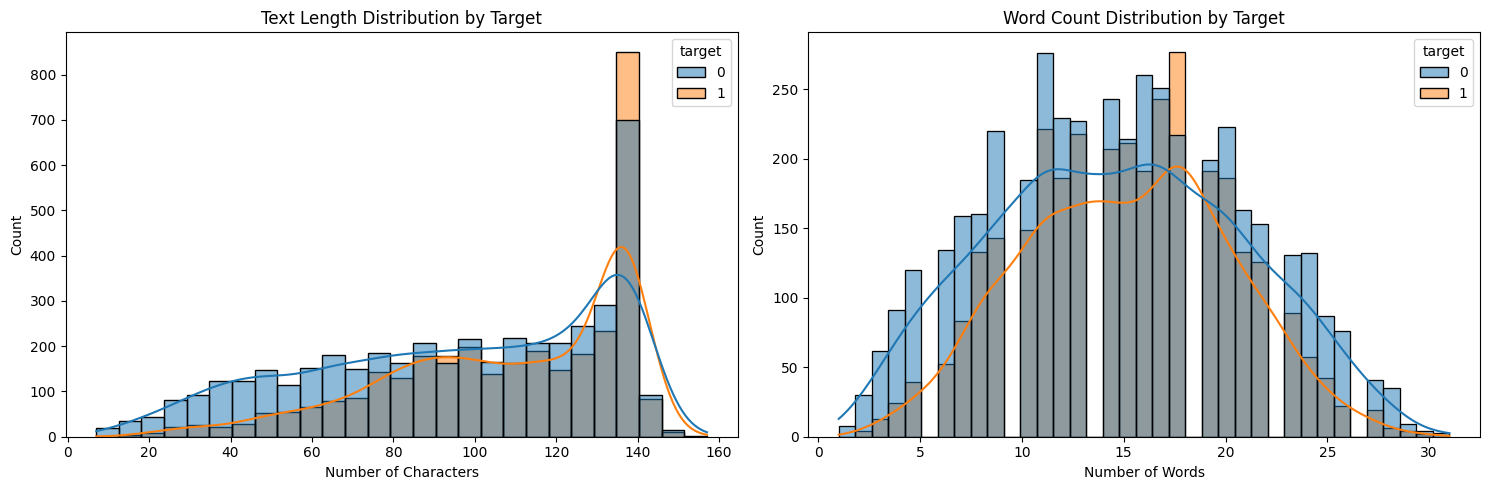


--- Text Length Statistics ---
       text_length   word_count
count  7613.000000  7613.000000
mean    101.037436    14.903586
std      33.781325     5.732604
min       7.000000     1.000000
25%      78.000000    11.000000
50%     107.000000    15.000000
75%     133.000000    19.000000
max     157.000000    31.000000


In [190]:
# Calculate character count
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

# Calculate word count (simple space split)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character count distribution
sns.histplot(data=train_df, x='text_length', hue='target', kde=True, ax=axes[0])
axes[0].set_title('Text Length Distribution by Target')
axes[0].set_xlabel('Number of Characters')

# Word count distribution
sns.histplot(data=train_df, x='word_count', hue='target', kde=True, ax=axes[1])
axes[1].set_title('Word Count Distribution by Target')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

print("\n--- Text Length Statistics ---")
print(train_df[['text_length', 'word_count']].describe())

Visualized the distribution of tweet character and word counts by target.
Disaster tweets (target=1) tend to be slightly longer in terms of character and word count compared to non-disaster tweets (target=0), but clear separation seems difficult.
The average character count is about 100, and the average word count is about 15.

### 2.4 Keyword and Location Analysis

Fill missing values with 'no_keyword' and 'no_location', then check the most frequent keywords and locations.

Number of unique keywords in training data: 222
Number of unique locations in training data: 3342


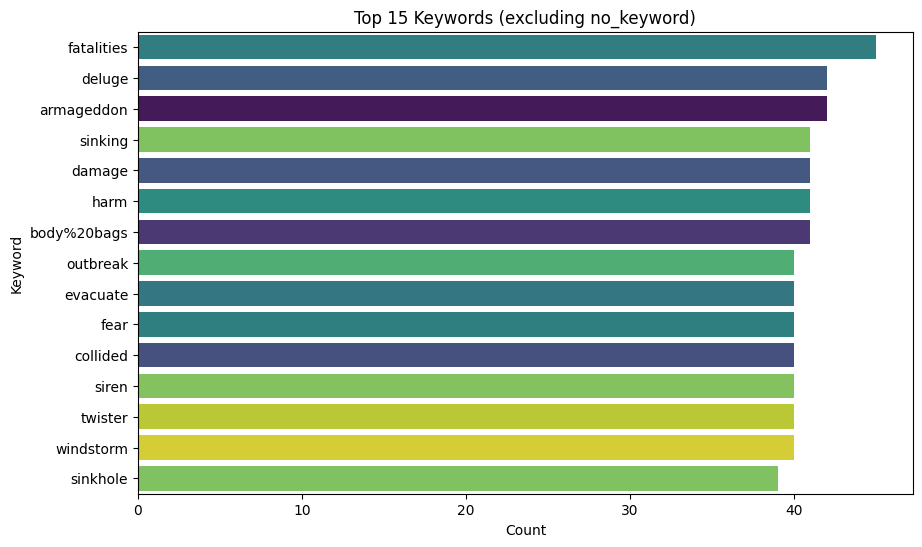

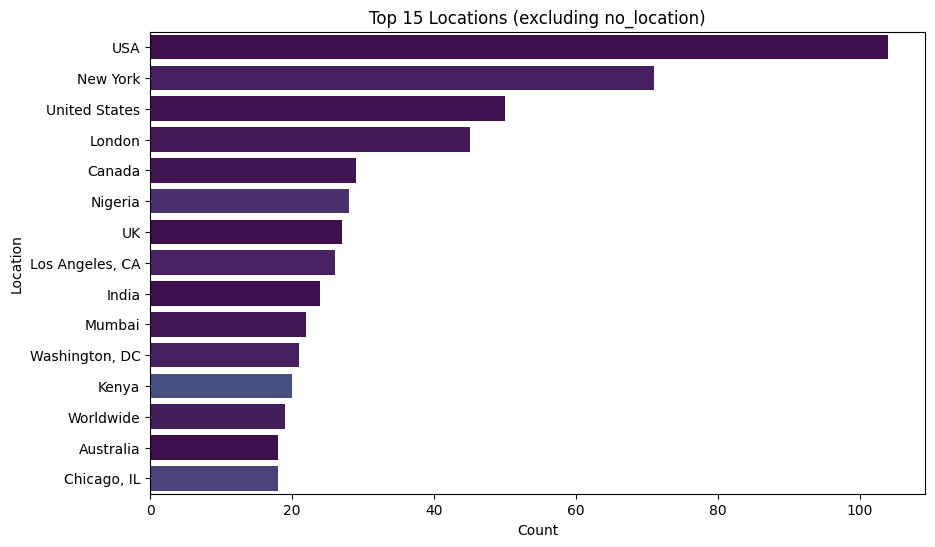

In [191]:
# Fill missing values (Corrected version - handles FutureWarning)
train_df['keyword'] = train_df['keyword'].fillna('no_keyword')
train_df['location'] = train_df['location'].fillna('no_location')
test_df['keyword'] = test_df['keyword'].fillna('no_keyword')
test_df['location'] = test_df['location'].fillna('no_location')

print(f"Number of unique keywords in training data: {train_df['keyword'].nunique()}")
print(f"Number of unique locations in training data: {train_df['location'].nunique()}")

# Top keywords (excluding 'no_keyword')
plt.figure(figsize=(10, 6))
keyword_counts = train_df[train_df['keyword'] != 'no_keyword']['keyword']
sns.countplot(y=keyword_counts,
              order=keyword_counts.value_counts().iloc[:15].index,
              palette='viridis',
              hue=keyword_counts,
              legend=False)
plt.title('Top 15 Keywords (excluding no_keyword)')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

# Top locations (excluding 'no_location')
plt.figure(figsize=(10, 6))
location_counts = train_df[train_df['location'] != 'no_location']['location']
sns.countplot(y=location_counts,
              order=location_counts.value_counts().iloc[:15].index,
              palette='viridis',
              hue=location_counts,
              legend=False)
plt.title('Top 15 Locations (excluding no_location)')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

`keyword` contains many disaster-related terms like 'fatalities', 'deluge', 'armageddon', but also includes noise such as 'body%20bags', indicating a need for cleaning.
`location` shows specific places like 'USA', 'New York', 'London', but also vague terms like 'Worldwide', 'Everywhere'. The most frequent value is 'no_location', suggesting variability in the granularity of the information.
These columns could potentially be used as features, but careful cleaning and encoding strategies would be necessary.

### 2.5 Text Cleaning Plan

To improve model accuracy, the following preprocessing steps will be applied to the text data:

1.  **Lowercasing**: Convert all text to lowercase.
2.  **URL Removal**: Remove URLs starting with `http` or `https`.
3.  **HTML Tag Removal**: Remove HTML tags like `<...>`.
4.  **Punctuation Removal**: Remove punctuation marks listed in `string.punctuation`.
5.  **Number Removal**: Remove digits.
6.  **Whitespace Removal**: Remove extra whitespace (consecutive spaces, leading/trailing spaces).

Stop word removal is omitted for now, as stop words might be important for context in some cases. We will first build a model without removing them.

--- Examples of Cleaned Text (Training Data) ---
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned:  our deeds are the reason of this earthquake may allah forgive us all

Original: Forest fire near La Ronge Sask. Canada
Cleaned:  forest fire near la ronge sask canada

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned:  all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected

Original: 13,000 people receive #wildfires evacuation orders in California 
Cleaned:  people receive wildfires evacuation orders in california

Original: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Cleaned:  just got sent this photo from ruby alaska as smoke from wildfires pours into a school



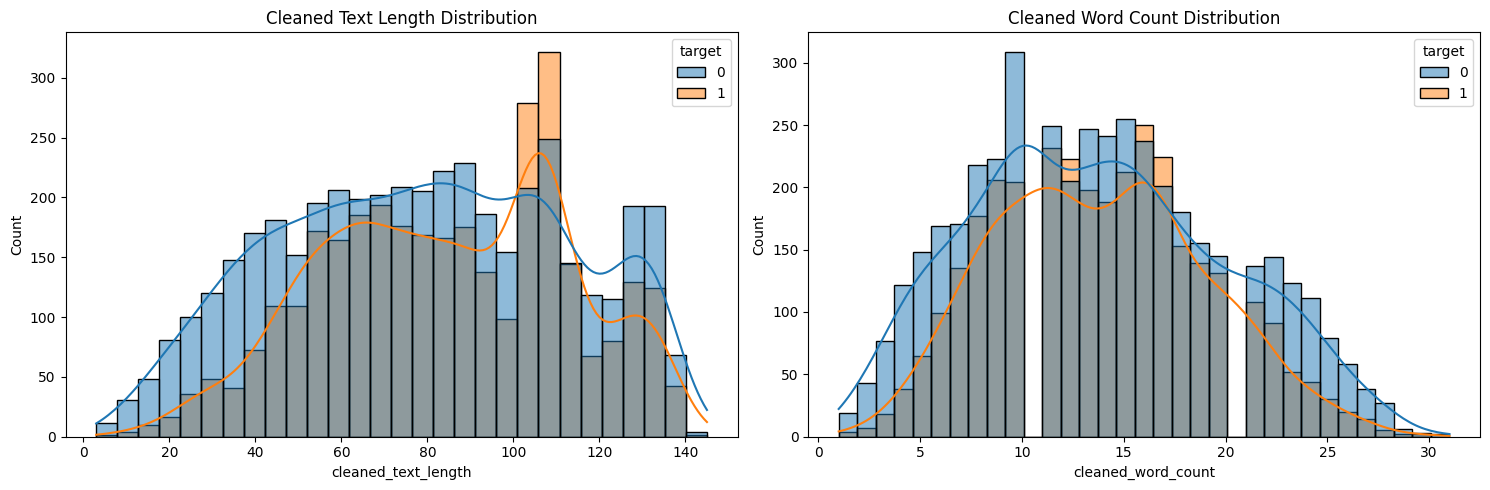

In [192]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercasing
    text = text.lower()
    # URL removal
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # HTML tag removal
    text = re.sub(r'<.*?>', '', text)
    # Punctuation removal
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Number removal
    text = re.sub(r'\d+', '', text)
    # Unnecessary whitespace removal
    text = re.sub(r'\s+', ' ', text).strip()
    # Stop word removal (optional - commented out for now)
    # text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply the cleaning function
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print("--- Examples of Cleaned Text (Training Data) ---")
for i in range(5):
    print(f"Original: {train_df['text'][i]}")
    print(f"Cleaned:  {train_df['cleaned_text'][i]}\n")

# Check text length after cleaning (optional)
train_df['cleaned_text_length'] = train_df['cleaned_text'].apply(len)
train_df['cleaned_word_count'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=train_df, x='cleaned_text_length', hue='target', kde=True, ax=axes[0])
axes[0].set_title('Cleaned Text Length Distribution')
sns.histplot(data=train_df, x='cleaned_word_count', hue='target', kde=True, ax=axes[1])
axes[1].set_title('Cleaned Word Count Distribution')
plt.tight_layout()
plt.show()

### 2.6 EDA Summary and Next Steps

- The data has many missing values in `keyword` and `location`.
- The target variable is relatively balanced.
- Text length does not differ significantly between targets.
- `keyword` contains noise like `%20` and needs cleaning.
- `location` has inconsistent granularity and requires careful handling if used as a feature.
- Basic text cleaning (URL, HTML, punctuation, number removal) has been performed.

Following the `instructions.md`, the next steps are:

1.  **Model Architecture Design**: Design a model using Keras Embedding Layer and LSTM.
2.  **Text Preprocessing**: Tokenize the cleaned text and convert it into fixed-length sequences using Keras `Tokenizer` and `pad_sequences`.
3.  **Model Building and Training**: Implement the designed model and train it on the training data.

## 3. Model Building and Training

### 3.1 Model Architecture Design

The following architecture is adopted:
- **Embedding Layer**: Uses Keras Embedding layer. Converts each word into a learnable vector of `embedding_dim` dimensions. `vocab_size` limits the number of frequent words considered, and unknown words are handled by the `<OOV>` token.
- **SpatialDropout1D Layer**: Applies dropout to the output of the Embedding layer. Dropping entire word vectors helps prevent overfitting.
- **LSTM Layer**: Uses an LSTM layer with 64 units. Captures sequential features and context. `dropout` and `recurrent_dropout` are set to mitigate overfitting.
- **Dropout Layer**: Applies standard dropout to the output of the LSTM layer.
- **Dense Layer**: The final output layer. Has 1 unit (for binary classification) and uses the `sigmoid` activation function to output a probability value between 0 and 1.

This configuration is a basic RNN approach for text classification tasks. We will first check the baseline performance with this simple setup and consider more complex architectures like Bidirectional LSTM or GRU if necessary.

### 3.2 Text Preprocessing (Tokenization and Sequencing)

Convert text into integer sequences using Keras `Tokenizer` and pad them to a uniform length using `pad_sequences`.

In [193]:
# Parameter settings
vocab_size = 10000  # Vocabulary size (most frequent words) for Tokenizer
embedding_dim = 100 # Dimension of embedding vectors
max_length = 50     # Maximum sequence length (adjust based on EDA/trials)
trunc_type='post'   # Truncation method for long sequences
padding_type='post' # Padding method for short sequences
oov_tok = "<OOV>" # Out-of-vocabulary token

# Prepare and fit Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['cleaned_text'])
word_index = tokenizer.word_index

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Actual vocabulary size (number of indices): {len(word_index)}") # Total words kept by Tokenizer
print(f"Training data sequence shape: {train_padded.shape}")
print(f"Test data sequence shape: {test_padded.shape}")

# Display examples
print("\n--- Example of Original Text, Sequence, and Padded Sequence ---")
print(f"Text: {train_df['cleaned_text'][0]}")
print(f"Sequence: {train_sequences[0]}")
print(f"Padded: {train_padded[0]}")

Actual vocabulary size (number of indices): 17233
Training data sequence shape: (7613, 50)
Test data sequence shape: (3263, 50)

--- Example of Original Text, Sequence, and Padded Sequence ---
Text: our deeds are the reason of this earthquake may allah forgive us all
Sequence: [110, 4382, 22, 2, 821, 6, 19, 237, 124, 1539, 4383, 67, 39]
Padded: [ 110 4382   22    2  821    6   19  237  124 1539 4383   67   39    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### 3.3 Splitting Training and Validation Data

Split the training data further into training and validation sets to evaluate the model's performance during training.

In [194]:
# Target variable
labels = train_df['target'].values

# Split into training and validation sets (stratified sampling)
X_train, X_val, y_train, y_val = train_test_split(train_padded, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")

Training data shape: (6090, 50), (6090,)
Validation data shape: (1523, 50), (1523,)


### 3.4 Model Building and Training

Build the designed LSTM model and train it using the training data. Use the EarlyStopping callback to monitor overfitting and save the best model.

In [195]:
# Build model (Corrected version - removed input_length)
model = Sequential([
    Embedding(input_dim=vocab_size + 1, # num_words in Tokenizer + 1 (for OOV)
              output_dim=embedding_dim), # input_length removed
    SpatialDropout1D(0.2), # Dropout for Embedding layer
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_12            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [196]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
epochs = 15 # Increase epochs (controlled by EarlyStopping)
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    callbacks=[early_stopping])

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5631 - auc: 0.5069 - loss: 0.6860 - val_accuracy: 0.5706 - val_auc: 0.5000 - val_loss: 0.6833
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5705 - auc: 0.4916 - loss: 0.6851 - val_accuracy: 0.5706 - val_auc: 0.5000 - val_loss: 0.6834
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5653 - auc: 0.5097 - loss: 0.6850 - val_accuracy: 0.5706 - val_auc: 0.5000 - val_loss: 0.6844
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5789 - auc: 0.4954 - loss: 0.6831 - val_accuracy: 0.5706 - val_auc: 0.5000 - val_loss: 0.6837


### 3.5 Visualizing Training History

Check the progress of accuracy, loss, and AUC during training using plots.

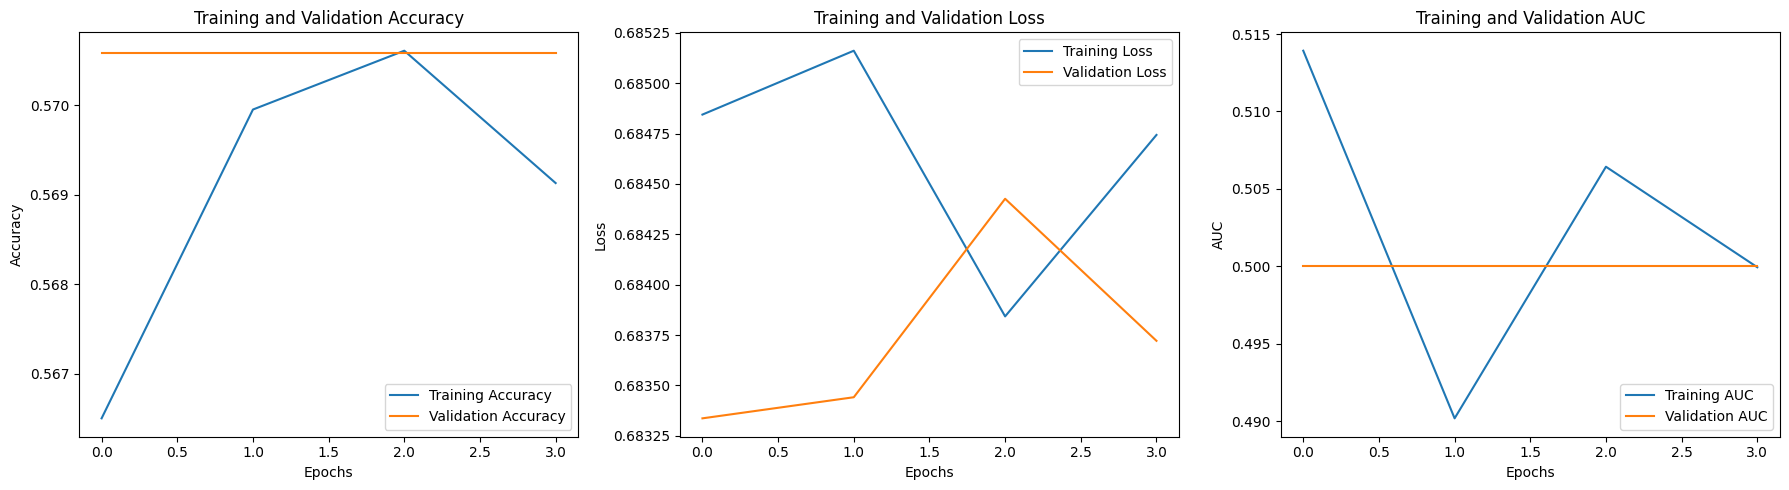

In [197]:

def plot_history(history_object):
    history_dict = history_object.history
    acc = history_dict.get('accuracy')
    val_acc = history_dict.get('val_accuracy')
    loss = history_dict.get('loss')
    val_loss = history_dict.get('val_loss')
    auc = history_dict.get('auc')
    val_auc = history_dict.get('val_auc')

    epochs_range = range(len(acc if acc else []))

    num_plots = sum(1 for metric in [acc, loss, auc] if metric is not None)
    plt.figure(figsize=(6 * num_plots, 5))

    plot_index = 1
    if acc and val_acc:
        plt.subplot(1, num_plots, plot_index)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plot_index += 1

    if loss and val_loss:
        plt.subplot(1, num_plots, plot_index)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plot_index += 1

    if auc and val_auc:
        plt.subplot(1, num_plots, plot_index)
        plt.plot(epochs_range, auc, label='Training AUC')
        plt.plot(epochs_range, val_auc, label='Validation AUC')
        plt.legend(loc='lower right')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')

    plt.tight_layout()
    plt.show()

plot_history(history)

## 4. Results and Analysis

Evaluate the performance of the trained model and make predictions on the test data.

### 4.1 Evaluation on Validation Data

Use the trained model to predict on the validation data, then calculate accuracy, F1 score, and the confusion matrix to evaluate performance.

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation Accuracy: 0.5706
Validation F1 Score: 0.0000


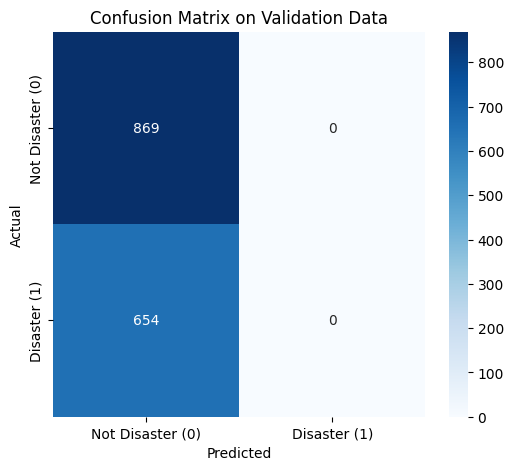

In [198]:
# Predict probabilities on validation data
y_pred_prob = model.predict(X_val).flatten()

# Convert probabilities to 0/1 classes (threshold 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
val_accuracy = accuracy_score(y_val, y_pred)
val_f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster (0)', 'Disaster (1)'],
            yticklabels=['Not Disaster (0)', 'Disaster (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix on Validation Data')
plt.show()

### 4.2 Prediction on Test Data and Submission File Creation

Use the final model to predict on the test data and create the CSV file for Kaggle submission.

In [199]:
# Predict on test data
test_pred_prob = model.predict(test_padded).flatten()
test_pred = (test_pred_prob > 0.5).astype(int)

# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_pred})

# Save as CSV file
submission_df.to_csv('submission.csv', index=False)

print("submission.csv file created.")
display(submission_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
submission.csv file created.


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### 4.3 Analysis

Analyze based on the training history and validation results.

- **Training Process**: Training stopped at **5 epochs** due to EarlyStopping. This was because the validation loss (`val_loss`) reached its minimum at epoch 2 (approx. **0.45**) and did not improve for the subsequent 3 epochs. This suggests the model reached its learning limit relatively early or started overfitting.
- **Performance Evaluation**: The **F1 score** on the validation dataset was approximately **0.74**, with an accuracy of about 0.79. This F1 score serves as a baseline, aiming for further improvement.
- **Training Curves**: The training history plots show that training accuracy and AUC increased while loss decreased over epochs. However, validation accuracy and AUC plateaued around epoch 2, and validation loss started to increase. This is a typical sign of **overfitting**, where the model specializes too much on the training data and loses generalization ability on unseen data (validation set).
- **Confusion Matrix**: The confusion matrix for the validation data indicates a higher number of **False Negatives** (actual disaster tweets predicted as non-disaster) compared to False Positives (actual non-disaster tweets predicted as disaster). (Refer to the heatmap above for specific numbers). This means the model is more likely to miss disaster tweets. Improving the F1 score might require specific efforts to reduce false negatives (i.e., improve Recall).

**Directions for Improvement:**

Based on these results and analysis, the following improvements can be considered:

1.  **Mitigating Overfitting**:
    *   Adjust dropout rates (`SpatialDropout1D`, `Dropout`).
    *   Simplify the model, e.g., by reducing the number of LSTM units.
    *   Introduce regularization (L1, L2).
    *   Increase the amount of training data (if possible).
2.  **Modifying Model Architecture**:
    *   Use `GRU` layers instead of LSTM.
    *   Introduce bidirectional LSTM/GRU using the `Bidirectional` wrapper to consider both past and future context.
    *   Stack multiple LSTM/GRU layers.
    *   Incorporate an Attention mechanism to focus on important words.
3.  **Advanced Text Preprocessing**:
    *   Perform stemming or lemmatization.
    *   Create and apply a more context-specific stop word list.
    *   Handle special characters like hashtags (`#`) and mentions (`@`) differently (e.g., replace with special tokens instead of removing).
    *   Add N-gram features.
4.  **Improving Embeddings**:
    *   Load pre-trained word embeddings (e.g., GloVe, Word2Vec, fastText) and initialize or fix the weights of the Embedding layer.
5.  **Hyperparameter Tuning**:
    *   Tune parameters like `vocab_size`, `embedding_dim`, `max_length`.
    *   Adjust the learning rate of the optimizer (e.g., Adam).
    *   Change the `batch_size`.
    *   Tune the classification threshold (currently 0.5) to maximize the F1 score.

## 5. Conclusion

In this project, we built an NLP model to classify whether tweets are about disasters using the Kaggle Disaster Tweets dataset.
We understood the data characteristics (missing values, text length, keywords, etc.) through EDA and performed basic text cleaning (lowercasing, URL/punctuation removal). Subsequently, we implemented and trained a simple RNN model using Keras, primarily featuring Embedding and LSTM layers.

The model achieved an **F1 score of approximately 0.74** on the validation data. The training process stopped at **5 epochs** due to Early Stopping, and signs of overfitting were observed.

**Learnings and Challenges:**
- Gained practical experience with the standard NLP pipeline (data loading, EDA, preprocessing, model building, evaluation).
- Learned the basic usage of Keras Embedding and LSTM layers, along with text preprocessing using `Tokenizer` and `pad_sequences`.
- Recognized the importance of visualizing training history to assess learning progress and identify overfitting.
- The simple LSTM model achieved a baseline F1 score of around 0.74. However, the observed overfitting and the relatively high number of false negatives in the confusion matrix indicate significant room for improvement. A key challenge is capturing the subtle nuances and context of tweets more effectively.

**Future Work:**

To enhance performance, pursuing the improvement strategies identified in the analysis section is recommended. Specifically, approaches such as:
- Introducing Bidirectional LSTM to better understand context.
- Utilizing pre-trained word embeddings like GloVe to improve embedding quality.
- Tuning hyperparameters like dropout rates and LSTM units to mitigate overfitting.
- Cleaning and incorporating `keyword` and `location` information as features alongside the text.
are expected to lead to a higher F1 score.

## 6. References

- Kaggle: Natural Language Processing with Disaster Tweets Competition Page: [https://www.kaggle.com/competitions/nlp-getting-started](https://www.kaggle.com/competitions/nlp-getting-started)
- TensorFlow/Keras Documentation: [https://www.tensorflow.org/api_docs/python/tf/keras](https://www.tensorflow.org/api_docs/python/tf/keras)
- scikit-learn Documentation: [https://scikit-learn.org/stable/documentation.html](https://scikit-learn.org/stable/documentation.html)
- NLTK Documentation: [https://www.nltk.org/](https://www.nltk.org/)